In [1]:
!nvidia-smi

Mon Feb  1 11:22:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   36C    P8    21W / 250W |  10490MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 27%   33C    P8     9W / 250W |   1639MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
# !tar -xf "/content/drive/MyDrive/gitLab/datasets/domain_adaptation_images.tar.gz" -C "/content/drive/MyDrive/gitLab/datasets/office"

In [1]:
import os
os.getcwd()
# base_dir = '/root/Master-Thesis'
# os.chdir(base_dir)

'/root/Master-Thesis/src'

In [2]:
import tensorflow as tf
from pathlib import Path
# import tensorflow_model_optimization as tfmot
# import tensorflow_probability as tfp
import zipfile
import pickle
import datetime
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model
# tf.random.set_seed(100)
tf.keras.backend.clear_session()  # For easy reset of notebook state.
initializer = tf.keras.initializers.he_normal()
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import layers
import seaborn as sns
import bokeh

In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
import pandas as pd
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [4]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [6]:
log_path = r"/root/Master-Thesis2/code/logs/5_Xception_SourceOnly/20210301-074025/training_logs.csv"

In [30]:
logdd = pd.read_csv(log_path,sep=";")

In [42]:
logdd

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.79990,0.692879,0.649927,1.561941
1,1,0.90773,0.303110,0.680711,1.504924
2,2,0.92021,0.261052,0.630493,1.848594
3,3,0.92686,0.238628,0.625112,2.057047
4,4,0.93665,0.202673,0.657222,1.882489
5,5,0.93965,0.193529,0.692520,1.698546
6,6,0.94184,0.184053,0.669464,2.073504
7,7,0.94339,0.181208,0.688974,2.026242
8,8,0.94562,0.169851,0.688184,2.005179
9,9,0.94622,0.168823,0.670407,2.232765


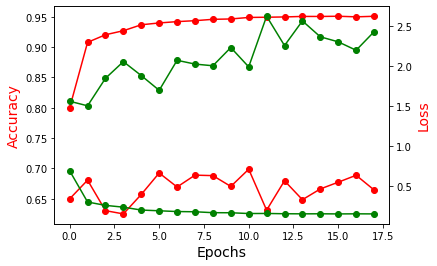

In [50]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(logdd.epoch, logdd.accuracy, color="red", marker="o")
ax.plot(logdd.epoch, logdd.val_accuracy,color="red",marker="o")
# set x-axis label
ax.set_xlabel("Epochs",fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(logdd.epoch, logdd.loss,color="green",marker="o")
ax2.plot(logdd.epoch, logdd.val_loss,color="green",marker="o")
ax2.set_ylabel("Loss",color="Red",fontsize=14)
plt.show()

In [9]:
initializer = tf.keras.initializers.he_normal()  # Layer initializations
BASE_DIR = Path("/root/Master-Thesis/code")
MNIST_M_PATH = BASE_DIR / Path("data/keras_mnistm.pkl")
OFFICE_DS_PATH = BASE_DIR / Path("data/office/")
LOGS_DIR = BASE_DIR / Path("logs/")  # Logs path
MODEL_PATH = BASE_DIR / Path("model_data/")  # Model path
EVALUATION = BASE_DIR / Path("evaluation/")  # Evalaution plots path
PRETRAINED_WEIGHTS = BASE_DIR / Path("pretrained_weights")
AUTOTUNE = tf.data.experimental.AUTOTUNE
DATASET_COMBINATION = {
    "Amazon_to_Webcam": 1,
    "Amazon_to_DSLR": 2,
    "Webcam_to_Amazon": 3,
    "Webcam_to_DSLR": 4,
    "DSLR_to_Amazon": 5,
    "DSLR_to_Webcam": 6,
    "MNIST_to_MNISTM": 7,
    "MNISTM_to_MNIST": 8,
    "SynSigns_to_GTSRB": 9,
    "GTSRB_to_SynSigns": 10,
}

Loss = {1: "CORAL", 2: "Other"}

# pruning_params = {
#     "pruning_schedule": tfmot.sparsity.keras.ConstantSparsity(
#         0.20, 0, end_step=-1, frequency=1
#     )
# }


## Preprocessing

In [10]:
source_directory = OFFICE_DS_PATH / "amazon"
target_directory = OFFICE_DS_PATH / "webcam"

In [11]:
source_directory

PosixPath('/root/Master-Thesis/code/data/office/amazon')

In [7]:
# def create_paths(path):
#     all_image_paths = [str(path) for path in list(path.glob("*/*"))]
#     label_names = sorted(item.name for item in path.glob("*/") if item.is_dir())
#     label_to_index = dict((name, index) for index, name in enumerate(label_names))

#     all_image_labels = [
#         label_to_index[Path(path).parent.name] for path in all_image_paths
#     ]

#     return all_image_paths, all_image_labels

In [8]:
# source_images_list, source_labels_list = create_paths(source_directory)
# target_images_list, target_labels_list = create_paths(target_directory)

In [9]:
# def read_images(file, label):
#     image = tf.io.read_file(file)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.cast(image, tf.float32)
#     image = tf.keras.applications.vgg16.preprocess_input(image)
#     image = tf.image.resize(image, [227, 227], method="nearest")
#     # image = image / 255.0
#     return image, label

In [12]:
source_ds = tf.keras.preprocessing.image_dataset_from_directory(
  source_directory,
  validation_split=0,
  image_size=(227, 227),
  batch_size=16,
  labels="inferred",
  interpolation="nearest",
  label_mode = "categorical")

Found 2817 files belonging to 31 classes.


In [13]:
source_ds.class_names

['back_pack',
 'bike',
 'bike_helmet',
 'bookcase',
 'bottle',
 'calculator',
 'desk_chair',
 'desk_lamp',
 'desktop_computer',
 'file_cabinet',
 'headphones',
 'keyboard',
 'laptop_computer',
 'letter_tray',
 'mobile_phone',
 'monitor',
 'mouse',
 'mug',
 'paper_notebook',
 'pen',
 'phone',
 'printer',
 'projector',
 'punchers',
 'ring_binder',
 'ruler',
 'scissors',
 'speaker',
 'stapler',
 'tape_dispenser',
 'trash_can']

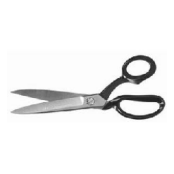

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in source_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(source_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
def augment_ds(image, label):

    # Make Images Greyscale
    image = tf.cond(
        tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4,
        lambda: tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 1, 3]),
        lambda: image,
    )

    # Adding Gaussian Noise
    noise = tf.random.normal(
        shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32
    )
    image = tf.cond(
        tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4,
        lambda: tf.add(image, noise),
        lambda: image,
    )

    # Colour Augmentations
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 2, 5)
    image = tf.image.random_brightness(image, max_delta=0.4)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    # Rotating Images
    image = tf.cond(
        tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4,
        lambda: tf.image.rot90(image, k=1),
        lambda: tf.image.rot90(image, k=3),
    )

    # Flipping Images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, label

In [9]:
def preprocess(image, label):
    # Cast to float32
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg16.preprocess_input(image)
    image = image / 255.0

    return image, label

In [10]:
def read_images(source_directory, batch_size, new_size):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        source_directory,
        labels="inferred",
        label_mode="int",  # categorical, binary
        batch_size=batch_size,
        image_size=(new_size, new_size),  # reshape if not in this size
        shuffle=True,
    )
    return ds

In [31]:
source_ds = read_images(source_directory, 16, 227)

Found 2817 files belonging to 31 classes.


In [12]:
source_ds.cardinality().numpy()

177

In [13]:
source_ds= source_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [14]:
source_ds = source_ds.map(augment_ds, num_parallel_calls=AUTOTUNE)

In [32]:
aa = next(iter(source_ds))

In [34]:
a1 = tf.keras.applications.xception.preprocess_input(aa[0])

In [37]:
np.min(np.array(a1))

-1.0

In [16]:
target_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
  target_directory,
  validation_split=0,
  image_size=(227, 227),
  batch_size=16,
  labels="inferred",
  interpolation="nearest",
  label_mode = "categorical")

Found 795 files belonging to 31 classes.


In [17]:
target_ds = target_ds_original.repeat(4)

In [18]:
target_ds = target_ds.map(preprocess).unbatch()
# target_ds = target_ds.map(preprocess).cache().shuffle(795).unbatch()

In [19]:
target_ds

<_UnbatchDataset shapes: ((227, 227, 3), (31,)), types: (tf.float32, tf.float32)>

In [20]:
  source_images, target_images, source_labels, target_labels = [], [], [], []
  for x, y in tf.data.Dataset.zip((source_ds, target_ds)):
      source_images.append(x[0])
      target_images.append(y[0])
      source_labels.append(x[1])
      target_labels.append(y[1])

  ds_train = tf.data.Dataset.from_tensor_slices(
        ((source_images, target_images), source_labels)
    )
  ds_train = ds_train.batch(32).prefetch(buffer_size=AUTOTUNE)


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [16,227,227,3] != values[176].shape = [1,227,227,3] [Op:Pack] name: component_0

In [ ]:
aa[1].shape

In [ ]:
x1, y1 = [], []
for x, y in target_ds_original.map(preprocess, num_parallel_calls=AUTOTUNE).unbatch():
    x1.append(x)
    y1.append(y)


In [ ]:
ds_test = (
    tf.data.Dataset.from_tensor_slices(((x1, x1), y1))
    .batch(32)
    .prefetch(buffer_size=AUTOTUNE)
)


In [ ]:
bb = next(iter(ds_test))

In [29]:
train_count = [x for x in ds_train]
print(f"Batch count of training set: {str(len(train_count))}")

test_count = [x for x in ds_test]
print(f"Batch count of test set: {str(len(test_count))}")

Batch count of training set: 89
Batch count of test set: 25


## Methods

In [29]:


base_model = tf.keras.applications.Xception(
    include_top=False, weights="imagenet", input_shape=(299,299,3), pooling="avg"
)

In [30]:
base_model.summary()

act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 19, 19, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 19, 19, 728)  0           block5_sepconv2_bn[0][0]  

In [30]:
def create_model(name, input_shape=(227, 227, 3), freeze_upto=15):
    base_model = tf.keras.applications.VGG16(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    for idx, layer in enumerate(base_model.layers):
        if idx < freeze_upto:
            layer.trainable = False
        else:
            layer.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x, name=name)
    return model

In [31]:
def CORAL(source_output, target_output, percent_lambda=0.75):

    source_batch_size = tf.cast(tf.shape(source_output)[0], tf.float32)
    target_batch_size = tf.cast(tf.shape(target_output)[0], tf.float32)
    d = tf.cast(tf.shape(source_output)[1], tf.float32)

    # Source covariance
    xm = source_output - tf.reduce_mean(source_output, 0, keepdims=True)
    xc = tf.matmul(tf.transpose(xm), xm) / source_batch_size

    # Target covariance
    xmt = target_output - tf.reduce_mean(target_output, 0, keepdims=True)
    xct = tf.matmul(tf.transpose(xmt), xmt) / target_batch_size

    # Frobenius norm
    # loss = tf.sqrt(tf.reduce_sum(tf.multiply((xc - xct), (xc - xct))))
    loss = tf.sqrt(tf.reduce_sum(tf.multiply((xc - xct), (xc - xct))))
    loss = loss / (4 * d * d)
    loss = percent_lambda * loss
    # model.add_loss(loss)
    return loss

In [54]:
def merged_model(
    input_shape,
    prune,
    num_classes=31,
    lambda_loss=0.75,
    additional_loss=CORAL,
    freeze_upto=15,
):
    source_model = create_model("source_fe", input_shape, freeze_upto=15)
    for layer in source_model.layers:
        layer._name = layer.name + str("_1")

    if prune:
        target_model = tfmot.sparsity.keras.prune_low_magnitude(
            create_model("target_fe", input_shape, freeze_upto), **cn.pruning_params
        )
    else:
        target_model = create_model("target_fe", input_shape, freeze_upto=15)

    for layer in target_model.layers:
        layer._name = layer.name + str("_2")

    prediction = layers.Dense(31, kernel_initializer=tf.initializers.RandomNormal(0, 0.005), name="prediction")(source_model.output)
    model = models.Model([source_model.input, target_model.input], prediction)

    # additive_loss = additional_loss(
    #     source_output=source_model.output,
    #     target_output=target_model.output,
    #     percent_lambda=lambda_loss,
    # )

    # model.add_loss(additive_loss)
    # model.add_metric(additive_loss, name="domain_loss")
    return model


In [33]:
def create_callbacks(my_dir="1_0.75", LOGS_DIR=LOGS_DIR, save_weights=True, MODEL_PATH= MODEL_PATH):

  callback_list = []
  assert os.path.exists(LOGS_DIR), "LOGS_DIR doesn't exist"
  experiment_logs_path = os.path.join(LOGS_DIR, my_dir)
  Path(experiment_logs_path).mkdir(parents=True, exist_ok=True)
  tb_logdir = os.path.join(LOGS_DIR, my_dir)
  Path(tb_logdir).mkdir(parents=True, exist_ok=True)
  assert os.path.exists(tb_logdir), "tb_logdir doesn't exist"
  tb_logdir = os.path.join(
      tb_logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  )
  log_dir = tb_logdir
  # file_writer = tf.summary.create_file_writer(tb_logdir + "/custom_evaluation")
  # file_writer.set_as_default()
  tensorboard_callback = tf.keras.callbacks.TensorBoard(tb_logdir, histogram_freq=1)
  callback_list.append(tensorboard_callback)
  tf.compat.v1.logging.info(f"Tensorboard logs path: {tb_logdir}")

  """CSV Logger Callback """
  Path(log_dir).mkdir(parents=True, exist_ok=True)
  csv = os.path.join(log_dir, "training_logs.csv")
  csv_logger = CSVLogger(
      csv,
      append=True,
      separator=";",
  )
  tf.compat.v1.logging.info(f"Model CSV logs path: {csv}")
  callback_list.append(csv_logger)

  """Reduce LR Callback """
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor="val_accuracy", factor=0.4, patience=2, min_lr=0.000001
  )
  callback_list.append(reduce_lr_callback)

  """Early Stopping Callback """
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor="val_accuracy",
      patience=15,
      verbose=1,
      mode="auto",
  )
  callback_list.append(early_stopping_callback)

  """Checkpoint Callback """
  if save_weights:
      assert os.path.exists(MODEL_PATH), "MODEL_PATH doesn't exist"
      checkpoint_path = os.path.join(
          MODEL_PATH, (Path(log_dir).parent).name, Path(log_dir).name
      )
      Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
      assert os.path.exists(checkpoint_path), "checkpoint_path doesn't exist"
      checkpoint_path = os.path.join(
          checkpoint_path,
          "weights.{epoch:02d}-{val_accuracy:.2f}.hdf5",
      )
      cp_callback = tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path,
          save_weights_only=True,
          save_best_only=True,
          verbose=1,
          monitor="val_accuracy",
      )
      callback_list.append(cp_callback)

  return callback_list, log_dir

In [34]:
def loss_accuracy_plots(
    hist,
    log_dir,
):
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(loss, "r", label="Training")
    plt.plot(val_loss, "r:", label="Validation")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracy, "g", label="Training")
    plt.plot(val_accuracy, "g:", label="Validation")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plot_path = os.path.join(
        EVALUATION, (Path(log_dir).parent).name, Path(log_dir).name
    )
    Path(plot_path).mkdir(parents=True, exist_ok=True)
    tf.compat.v1.logging.info("Plots created at: " + plot_path)
    plot_path = os.path.join(plot_path, "Accuracy_Loss_Plots.png")
    plt.savefig(plot_path)
    plt.show()


In [35]:
 def save_model(MODEL_PATH, log_dir):
    tf.compat.v1.logging.info("Saving the model...")
    model_path = os.path.join(
        MODEL_PATH, (Path(log_dir).parent).name, Path(log_dir).name
    )
    Path(model_path).mkdir(parents=True, exist_ok=True)
    model.save(os.path.join(model_path, "model.h5"))
    tf.compat.v1.logging.info(f"Model successfully saved at: {model_path}")


## Run 1

In [41]:
temp_plot = create_model("VGG16")
plot_model(temp_plot, "FeatureExtractors.png", show_shapes=True, expand_nested=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [42]:
xx = source_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

In [59]:
base_model = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=(227,227,3)
)
for idx, layer in enumerate(base_model.layers):
    if idx < 15:
        layer.trainable = False
    else:
        layer.trainable = True

inputs = tf.keras.Input(shape=(227,227,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(31, kernel_initializer=initializer, activation = "softmax")(x)
mdl = tf.keras.models.Model(inputs=inputs, outputs=x, name="Testing")

In [60]:
mdl.summary()

Model: "Testing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                15903     
Total params: 14,730,591
Trainable params: 7,095,327
Non-trainable params: 7,635,264
_________________________________________________________________


In [64]:
mdl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics="accuracy")

In [63]:
mdl.trainable = True

In [62]:
mdlhist = None
mdlhist = mdl.fit(
    xx,
    epochs=20,
    verbose=1,
    callbacks=callback_list,
)

Epoch 1/20
     26/Unknown - 21s 816ms/step - loss: 3.4603 - accuracy: 0.0276

KeyboardInterrupt: 

Epoch 1/20
22/89 [======>.......................] - ETA: 53s - loss: 4.8472 - accuracy: 0.0398

KeyboardInterrupt: 

In [36]:
run2 = merged_model(
          input_shape=(227, 227, 3),
          num_classes=31,
          lambda_loss=0.75,
          additional_loss=CORAL,
          prune=False,
          freeze_upto=15,
      )


In [37]:
run2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2_1 (InputLayer)          [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
vgg16_1 (Functional)            (None, 7, 7, 512)    14714688    input_2_1[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg16_1[0][0]                    
__________________________________________________________________________________________________
input_4_2 (InputLayer)          [(None, 227, 227, 3) 0                                            
_______________________________________________________________________________________

In [ ]:
# plot_model(model, "DDAN.png", show_shapes=True, expand_nested=False)

In [38]:
run2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics="accuracy")

In [39]:
callback_list, log_dir = create_callbacks("1_0.75")

INFO:tensorflow:Tensorboard logs path: /root/Master-Thesis/logs/1_0.75/20210122-233820
INFO:tensorflow:Model CSV logs path: /root/Master-Thesis/logs/1_0.75/20210122-233820/training_logs.csv


In [40]:
run2hist = None
run2hist = run2.fit(
    ds_train,
    validation_data=ds_test,
    epochs=50,
    verbose=1,
    callbacks=callback_list,
)

Epoch 1/50
 1/89 [..............................] - ETA: 0s - loss: 3.5489 - accuracy: 0.0312WARNING:tensorflow:From /opt/conda/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
53/89 [================>.............] - ETA: 30s - loss: 3.5391 - accuracy: 0.0377

KeyboardInterrupt: 

In [ ]:
loss_accuracy_plots(
        hist=hist2,
        log_dir=log_dir,
    )

In [ ]:
loss_accuracy_plots(
        hist=run1hist,
        log_dir=log_dir,
    )

## Run 2

In [ ]:
# for layer in modell.get_layer("Target").layers:
#         print(layer._name)

In [ ]:
# for idx, layers in enumerate(model.layers):
#   print(idx, layers.name)
